In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import os
import pandas as pd
from torchvision.io import decode_image
import json
from torch.utils.data import Dataset, DataLoader
import cv2
import plotly_express as px

## CNN for digits recognition

In [69]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters 
num_epochs = 10
batch_size = 6
learning_rate = 0.1

In [3]:
# ---------- preprocess ----------
def leave_only_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = (0, 0, 200)
    upper_white = (180, 40, 255)
    mask = cv2.inRange(hsv, lower_white, upper_white)
    result = img.copy()
    result[mask == 0] = [0, 0, 0]
    return result

def preprocess_image(image_bgr):
    h, _ = image_bgr.shape[:2]
    crop = image_bgr[(h - 39):(h - 26), 107:210]  # (13, ~103, 3)
    crop = leave_only_white(crop)
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY) # (13, ~103)
    return gray

def is_blank(patch_gray, thr=0):
    return np.all(patch_gray <= thr)


In [ ]:
# ---------------------------
# BUILDING MY OWN DATASET
# ---------------------------

class ScoreToDigitsDataset(Dataset):
    """
    Each __getitem__ returns one digit image and its class (0..9).
    Not labeled images are ignored.
    """
    def __init__(self, labels_json, img_dir,
                 n_slots=8, slot_w=8,
                 resize_hw=(20, 14),
                 return_blank=False):
        self.img_dir = img_dir
        self.n_slots = n_slots
        self.slot_w = slot_w
        self.resize_hw = resize_hw
        self.return_blank = return_blank

        with open(labels_json, "r", encoding="utf-8") as f:
            self.labels = json.load(f)

        # Build an index mapping: each sample = (image_path, slot_index, digit_class)
        self.samples = []
        for item in self.labels:
            fn = item.get("image")
            length = item.get("length", None)

            if fn is None:
                continue
            if length is None:
                continue  # skip unknown labels

            s = str(int(length))
            # align digits to the RIGHT: last digit goes to last slot
            # Example: length=62, s="62" => slot 7:'2', slot 6:'6'

            for k, ch in enumerate(s):
                slot = k
                if slot >= self.n_slots:
                    break
                self.samples.append((fn, slot, int(ch)))

            # include unknown/blank as class 10
            if self.return_blank:
                used_slots = set((self.n_slots - 1) - k for k in range(min(len(s), self.n_slots)))
                for slot in range(self.n_slots):
                    if slot not in used_slots:
                        self.samples.append((fn, slot, 10))  # unknown class

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fn, slot, digit_class = self.samples[idx]
        path = os.path.join(self.img_dir, fn)

        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(path)

        score_gray = preprocess_image(img)  # (13, W)

        x1 = max(0, slot * self.slot_w)
        x2 = min(score_gray.shape[1], (slot + 1) * self.slot_w)
        patch = score_gray[:, x1:x2]


        # Resize to match your network input size (so you don't have to rewrite ConvNet)
        H, W = self.resize_hw
        patch_resized = cv2.resize(patch, (W, H), interpolation=cv2.INTER_CUBIC)

        # to torch: [1, H, W], float32 in [0,1]
        x = torch.from_numpy(patch_resized).unsqueeze(0).float() / 255.0
        y = torch.tensor(digit_class, dtype=torch.long)

        return x, y


In [ ]:
batch_size = 64

train_digits = ScoreToDigitsDataset(
    labels_json="../data/train/labels_score.json",
    img_dir="../data/train/screenshots",
    n_slots=8,
    slot_w=8,
    resize_hw=(20, 14),
    return_blank=False
)

test_digits = ScoreToDigitsDataset(
    labels_json="../data/test/labels_score.json",
    img_dir="../data/test/screenshots",
    n_slots=8,
    slot_w=8,
    resize_hw=(20, 14),
    return_blank=False
)

train_loader = DataLoader(train_digits, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_digits,  batch_size=batch_size, shuffle=False)


In [40]:
x, y = test_digits[0]
print(x.shape, y)

torch.Size([1, 20, 14]) tensor(2)


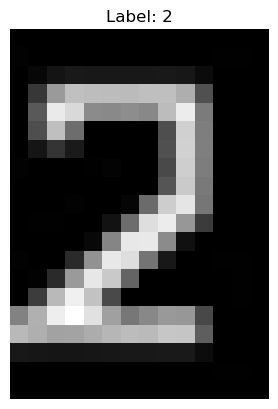

In [ ]:
import matplotlib.pyplot as plt

def show_sample(dataset, idx):
    x, y = dataset[idx]
    img = x.squeeze(0).numpy()  # (20,14)

    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {y}")
    plt.axis("off")
    plt.show()

show_sample(train_digits, 45)

In [96]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        #self.dnjef = nn.Conv2d(in_channels=, out_channels=, kernel_size=)
        self.conv1 = nn.Conv2d(1, 3, 5) # I only have 1 channel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 1, 80)
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 10) # predict 10 classes for the 10 digits.

    def forward(self, x):
        # -> n_batch, 1, 30, 65
        x = self.pool(F.relu(self.conv1(x)))  # -> nn_batch, 3, 13, 30
        x = (F.relu(self.conv2(x)))  # -> n_batch, 12, 4, 13
        x = x.view(-1, 12 * 4 * 1)            # -> n_batch, 400
        x = F.relu(self.fc1(x))               # -> n_batch, 120
        x = F.relu(self.fc2(x))               # -> n_batch, 84
        x = self.fc3(x)                       # -> n_batch, 10
        return x

model = ConvNet().to(device)

#relevant in classification
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

"""
# relevant for regression
criterion = nn.L1Loss() #nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
"""

'\n# relevant for regression\ncriterion = nn.L1Loss() #nn.MSELoss() \noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n'

In [ ]:
# loss curve over epochs

train_losses = []
test_losses = []
train_accs = []
test_accs = []
train_accs_per_class = {}
test_accs_per_class = {}

for epoch in range(num_epochs):
    # -------------------
    # TRAIN
    # -------------------
    model.train()
    train_loss_sum = 0.0
    train_n = 0
    correct = 0
    total=0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)  # [B]

        outputs = model(images)     # [B,10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        train_loss_sum += loss.item() * bs
        train_n += bs

        # accuracy --------
        preds = torch.argmax(outputs, dim=1)  # [B]
        correct += (preds == labels).sum().item()
        total += bs

        ...

    avg_train_loss = train_loss_sum / train_n
    train_losses.append(avg_train_loss)
    
    avg_train_acc = correct / total
    train_accs.append(avg_train_acc)

    # -------------------
    # TEST (eval)
    # -------------------
    model.eval()
    test_loss_sum = 0.0
    test_n = 0
    correct = 0
    total=0

    with torch.no_grad(): # avoid back-propagation in testing
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            test_loss_sum += loss.item() * bs
            test_n += bs

            preds = torch.argmax(outputs, dim=1)  # [B]
            correct += (preds == labels).sum().item()
            total += bs

    avg_test_loss = test_loss_sum / test_n
    avg_test_acc = correct / total

    test_losses.append(avg_test_loss)
    test_accs.append(avg_test_acc)


    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}"
        f"Train Acc: {avg_train_acc:.4f} | Test Acc: {avg_test_acc:.4f}"

    )

print("Finished Training")

# Save model
PATH = "./cnn.pth"
#torch.save(model.state_dict(), PATH)
print("Saved: loss_curves.html")

# -------------------
# Plot loss curves
# -------------------
df_loss = pd.DataFrame({
    "epoch": list(range(1, num_epochs + 1)),
    "train_loss": train_losses,
    "test_loss": test_losses
})

df_long = df_loss.melt(id_vars="epoch", var_name="split", value_name="loss")

fig = px.line(
    df_long,
    x="epoch",
    y="loss",
    color="split",
    markers=True,
    title="Training vs Testing Loss (per epoch)"
)
fig.show()

df_acc = pd.DataFrame({
    "epoch": list(range(1, num_epochs + 1)),
    "train_acc": train_accs,
    "test_acc": test_accs
})
df_long = df_acc.melt(id_vars="epoch", var_name="split", value_name="accuracy")

fig = px.line(
    df_long,
    x="epoch",
    y="accuracy",
    color="split",
    markers=True,
    title="Training vs Testing Loss (per epoch)"
)
fig.show()


print("Saved: loss_curves.html")


Epoch [1/10] Train Loss: 2.2876 | Test Loss: 2.2891Train Acc: 0.1334 | Test Acc: 0.1505
Epoch [2/10] Train Loss: 2.2664 | Test Loss: 2.2943Train Acc: 0.1469 | Test Acc: 0.1505
Epoch [3/10] Train Loss: 2.2519 | Test Loss: 2.2692Train Acc: 0.1509 | Test Acc: 0.2476
Epoch [4/10] Train Loss: 2.1475 | Test Loss: 2.0449Train Acc: 0.1995 | Test Acc: 0.2039
Epoch [5/10] Train Loss: 1.5251 | Test Loss: 1.7660Train Acc: 0.4434 | Test Acc: 0.5971
Epoch [6/10] Train Loss: 1.2643 | Test Loss: 1.3135Train Acc: 0.5795 | Test Acc: 0.5922
Epoch [7/10] Train Loss: 0.8523 | Test Loss: 0.4636Train Acc: 0.7385 | Test Acc: 0.8544
Epoch [8/10] Train Loss: 0.4782 | Test Loss: 0.2533Train Acc: 0.8288 | Test Acc: 0.9320
Epoch [9/10] Train Loss: 0.3445 | Test Loss: 0.7169Train Acc: 0.8949 | Test Acc: 0.8398
Epoch [10/10] Train Loss: 0.3071 | Test Loss: 0.1398Train Acc: 0.8962 | Test Acc: 0.9223
Finished Training
Saved: loss_curves.html


Saved: loss_curves.html
